## Modellierung (1)

Multiple lineare Regression nach Raumstruktur (stadt-land-intermediär & sozioökonomische-Faktoren)
1) ohne sozioökonomische Faktoren
2) dann Erweiterung

unabhängige Variable (X-Parameter) :
- Numerisch: Alter
- Kategorisch: Haushaltseinkommen, Geschlecht, Raum

abhängige Variable (Y-Parameter) : 
- CO₂-Emissionen

Szenario-Analyse: 
Analog zu Literatur-Erkenntnissen (e.g., Bevölkerungszuwachs in Städten etc.)

## 0. Vorbereitung: Import der benötigten Python-Libraries 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import sklearn as sklearn

In [2]:
# Laden der Datei wege.gpkg
wege = gpd.read_file('wege.gpkg')

# Anzeigen der ersten Zeilen der Datei
wege.head()

,HHNR,HH_BFS_NR,HH_PLZ,HH_ORT,HH_KANTON,HH_OEV_GUETEKLASSE,HH_STADT_LAND,HH_HAUSHALTSGROESSE,HH_HAUSHALTSEINKOMMEN,ZP_ALTER,...,FAHRZEUG_ENERGIEEFFIZIENZKLASSE,FAHRZEUG_VERBRAUCH,EL_Verbrauch,FAHRZEUG_JAHR_ERSTE_INVERKEHRSSETZUNG,ABSCHNITTLÄNGE_IN_KM,HH_RAUMTYPOLOGIE_9,CO2E_KG_KM_AUTO,CO2E_KG_KM_OTHER,CO2E_TOTAL,geometry
0,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,0.414223,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,83.010354,"LINESTRING Z (2532653.357 1155702.624 420.558,..."
1,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,0.307909,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,61.705018,"LINESTRING Z (2532933.573 1155665.561 430.418,..."
2,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,0.586282,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,117.490869,"LINESTRING Z (2533071.108 1155894.339 430.657,..."
3,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,1.599024,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,320.444438,MULTILINESTRING Z ((2532653.357 1155702.624 41...
4,110001,5624,1030,Bussigny,22,3,Städtisch (1),2,5,57,...,D,-99.0,-99.0,-97.0,2.445678,Städtische Gemeinde einer grossen Agglomeratio...,200.4,NaN,490.113940,"LINESTRING Z (2532957.334 1156871.023 475.614,..."


In [3]:
print(wege.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 552622 entries, 0 to 552621
Data columns (total 41 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   HHNR                                   552622 non-null  int64   
 1   HH_BFS_NR                              552622 non-null  int64   
 2   HH_PLZ                                 552622 non-null  int64   
 3   HH_ORT                                 552622 non-null  object  
 4   HH_KANTON                              552622 non-null  int64   
 5   HH_OEV_GUETEKLASSE                     552622 non-null  int64   
 6   HH_STADT_LAND                          552622 non-null  object  
 7   HH_HAUSHALTSGROESSE                    552622 non-null  int64   
 8   HH_HAUSHALTSEINKOMMEN                  552622 non-null  int64   
 9   ZP_ALTER                               552622 non-null  int64   
 10  ZP_GESL                             

In [4]:
# Verschiedene Werte HH_STADT_LAND anzeigen
wege['HH_STADT_LAND'].unique()

array(['Städtisch (1)', 'Intermediär (2)', 'Ländlich (3)'], dtype=object)

In [5]:
# Umwandlung von HH_STADT_LAND
wege['HH_STADT_LAND'] = wege['HH_STADT_LAND'].map({
    'Städtisch (1)': 1,
    'Intermediär (2)': 2,
    'Ländlich (3)': 3
})

### Korrelationsanalyse

                       ZP_ALTER   ZP_GESL  HH_HAUSHALTSEINKOMMEN  CO2E_TOTAL  \
ZP_ALTER               1.000000 -0.002659               0.360617    0.035641   
ZP_GESL               -0.002659  1.000000              -0.058462   -0.035561   
HH_HAUSHALTSEINKOMMEN  0.360617 -0.058462               1.000000    0.033423   
CO2E_TOTAL             0.035641 -0.035561               0.033423    1.000000   
HH_STADT_LAND         -0.010418 -0.016326              -0.005035    0.083180   

                       HH_STADT_LAND  
ZP_ALTER                   -0.010418  
ZP_GESL                    -0.016326  
HH_HAUSHALTSEINKOMMEN      -0.005035  
CO2E_TOTAL                  0.083180  
HH_STADT_LAND               1.000000  


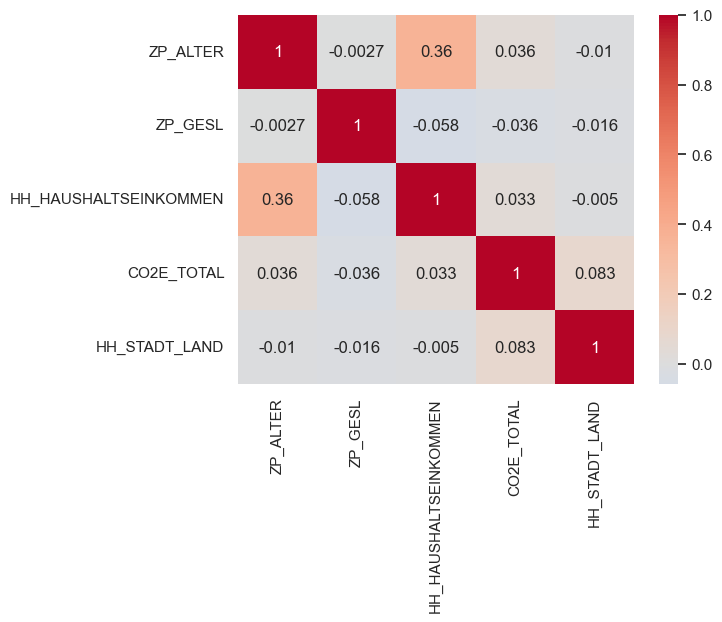

In [6]:
# Korrelation überprüfen
correlation_matrix = wege[['ZP_ALTER', 'ZP_GESL', 'HH_HAUSHALTSEINKOMMEN', 'CO2E_TOTAL', 'HH_STADT_LAND']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

Das dargestellte DataFrame zeigt die Korrelationsmatrix zwischen den Variablen. Korrelationskoeffizienten variieren zwischen -1 (perfekte negative Korrelation) und 1 (perfekte positive Korrelation), wobei 0 keine Korrelation bedeutet.

Zu beobachten ist, dass ZP_ALTER positiv korreliert mit dem Haushaltseinkommen (0.36). Das könnte darauf hinweisen , dass ältere Zielpersonen tendenziell ein höheres Einkommen haben.
Für uns von Bedeutung ist die Korrelation zwischen CO2E_TOTAL und HH_STADT_LAND. Diese ist positiv (0.083), wenn auch schwach, was möglicherweise bedeutet, dass Menschen in unterschiedlichen Regionen (Stadt, Land oder intermediär) leicht variierende Emissionsmuster aufweisen.

## 2. Vorverarbeitung der Daten


Die Verarbeitung wurde bei der Bearbeitung des Originaldatensatzes bzw. bei der Ermittlung der CO₂-Werte grösstenteils bereits abgeschlossen. Es sind lediglich minimale Anpassungen erforderlich, um kategoriale Werte in numerische Dummy-Variablen umzuwandeln. Dies betrifft ausschliesslich den Parameter HH_STADT_LAND und HH_HAUSHALTSEINKOMMEN da die Dummy-Variablen für die übrigen Parameter bereits erstellt wurden.

In [7]:
# 2.1. Nur relevante Variablen beibehalten
wege_bereinigt = wege[['CO2E_TOTAL', 'ZP_ALTER', 'ZP_GESL', 'HH_HAUSHALTSEINKOMMEN', 'HH_STADT_LAND', 'geometry']]

# Datensatz bereinigen: Nur Zeilen mit nicht-leeren Werten in den relevanten Spalten
wege_bereinigt = wege_bereinigt.dropna()

In [8]:
wege_bereinigt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 473372 entries, 0 to 552621
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   CO2E_TOTAL             473372 non-null  float64 
 1   ZP_ALTER               473372 non-null  int64   
 2   ZP_GESL                473372 non-null  int64   
 3   HH_HAUSHALTSEINKOMMEN  473372 non-null  int64   
 4   HH_STADT_LAND          473372 non-null  int64   
 5   geometry               473372 non-null  geometry
dtypes: float64(1), geometry(1), int64(4)
memory usage: 25.3 MB


In [9]:
### 2.2. Transformation von Werten (Dummy Variablen)

# Die Werte in ZP_GESL bedeuten: 1 = Mann und 2 = Frau
# Männer werden weggelassen, da sie als Referenzkategorie dienen, somit wird nur die Variable ZP_GESL_2 benötigt (Frauen)

wege_bereinigt = pd.get_dummies(wege_bereinigt, columns=['ZP_GESL'], drop_first=True)

# In Integer umwandeln
wege_bereinigt['ZP_GESL_2'] = wege_bereinigt['ZP_GESL_2'].astype(int)


In [10]:
wege_bereinigt.head()

,CO2E_TOTAL,ZP_ALTER,HH_HAUSHALTSEINKOMMEN,HH_STADT_LAND,geometry,ZP_GESL_2
0,83.010354,57,5,1,"LINESTRING Z (2532653.357 1155702.624 420.558,...",0
1,61.705018,57,5,1,"LINESTRING Z (2532933.573 1155665.561 430.418,...",0
2,117.490869,57,5,1,"LINESTRING Z (2533071.108 1155894.339 430.657,...",0
3,320.444438,57,5,1,MULTILINESTRING Z ((2532653.357 1155702.624 41...,0
4,490.113940,57,5,1,"LINESTRING Z (2532957.334 1156871.023 475.614,...",0


In [11]:
# HH_STADT_LAND Stadt(1) wird weg gelassen, da sie die Referenzklasse ist
wege_bereinigt = pd.get_dummies(wege_bereinigt, columns=['HH_STADT_LAND'], drop_first=True)
wege_bereinigt.head()

,CO2E_TOTAL,ZP_ALTER,HH_HAUSHALTSEINKOMMEN,geometry,ZP_GESL_2,HH_STADT_LAND_2,HH_STADT_LAND_3
0,83.010354,57,5,"LINESTRING Z (2532653.357 1155702.624 420.558,...",0,False,False
1,61.705018,57,5,"LINESTRING Z (2532933.573 1155665.561 430.418,...",0,False,False
2,117.490869,57,5,"LINESTRING Z (2533071.108 1155894.339 430.657,...",0,False,False
3,320.444438,57,5,MULTILINESTRING Z ((2532653.357 1155702.624 41...,0,False,False
4,490.113940,57,5,"LINESTRING Z (2532957.334 1156871.023 475.614,...",0,False,False


In [12]:
# Dummy-Variablen in numerische Werte umwandeln
wege_bereinigt['HH_STADT_LAND_2'] = wege_bereinigt['HH_STADT_LAND_2'].astype(int)
wege_bereinigt['HH_STADT_LAND_3'] = wege_bereinigt['HH_STADT_LAND_3'].astype(int)

In [13]:
wege_bereinigt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 473372 entries, 0 to 552621
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   CO2E_TOTAL             473372 non-null  float64 
 1   ZP_ALTER               473372 non-null  int64   
 2   HH_HAUSHALTSEINKOMMEN  473372 non-null  int64   
 3   geometry               473372 non-null  geometry
 4   ZP_GESL_2              473372 non-null  int32   
 5   HH_STADT_LAND_2        473372 non-null  int32   
 6   HH_STADT_LAND_3        473372 non-null  int32   
dtypes: float64(1), geometry(1), int32(3), int64(2)
memory usage: 23.5 MB


In [14]:
# Umwandlung von HH_HAUSHALTSEINKOMMEN

# Bedeutung der Kategorien:
# - -99	Nicht gestellt, da Zielperson jünger als 18 ist
# - -98	keine Antwort
# - -97	weiss nicht
# Es macht keinen Sinn, dass eine dieser Kategorien die Referenzkategorie ist. Deshalb werden die Daten gelöscht. 
wege_bereinigt = wege_bereinigt[~wege_bereinigt['HH_HAUSHALTSEINKOMMEN'].isin([-99, -98, -97])]

# Dummy-Variablen erstellen und die Referenzkategorie auf HH_HAUSHALTSEINKOMMEN_1 setzen
wege_bereinigt = pd.get_dummies(wege_bereinigt, columns=['HH_HAUSHALTSEINKOMMEN'], drop_first=True)

wege_bereinigt.head()

,CO2E_TOTAL,ZP_ALTER,geometry,ZP_GESL_2,HH_STADT_LAND_2,HH_STADT_LAND_3,HH_HAUSHALTSEINKOMMEN_2,HH_HAUSHALTSEINKOMMEN_3,HH_HAUSHALTSEINKOMMEN_4,HH_HAUSHALTSEINKOMMEN_5,HH_HAUSHALTSEINKOMMEN_6,HH_HAUSHALTSEINKOMMEN_7,HH_HAUSHALTSEINKOMMEN_8,HH_HAUSHALTSEINKOMMEN_9
0,83.010354,57,"LINESTRING Z (2532653.357 1155702.624 420.558,...",0,0,0,False,False,False,True,False,False,False,False
1,61.705018,57,"LINESTRING Z (2532933.573 1155665.561 430.418,...",0,0,0,False,False,False,True,False,False,False,False
2,117.490869,57,"LINESTRING Z (2533071.108 1155894.339 430.657,...",0,0,0,False,False,False,True,False,False,False,False
3,320.444438,57,MULTILINESTRING Z ((2532653.357 1155702.624 41...,0,0,0,False,False,False,True,False,False,False,False
4,490.113940,57,"LINESTRING Z (2532957.334 1156871.023 475.614,...",0,0,0,False,False,False,True,False,False,False,False


In [15]:
print(wege_bereinigt.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 357684 entries, 0 to 552621
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   CO2E_TOTAL               357684 non-null  float64 
 1   ZP_ALTER                 357684 non-null  int64   
 2   geometry                 357684 non-null  geometry
 3   ZP_GESL_2                357684 non-null  int32   
 4   HH_STADT_LAND_2          357684 non-null  int32   
 5   HH_STADT_LAND_3          357684 non-null  int32   
 6   HH_HAUSHALTSEINKOMMEN_2  357684 non-null  bool    
 7   HH_HAUSHALTSEINKOMMEN_3  357684 non-null  bool    
 8   HH_HAUSHALTSEINKOMMEN_4  357684 non-null  bool    
 9   HH_HAUSHALTSEINKOMMEN_5  357684 non-null  bool    
 10  HH_HAUSHALTSEINKOMMEN_6  357684 non-null  bool    
 11  HH_HAUSHALTSEINKOMMEN_7  357684 non-null  bool    
 12  HH_HAUSHALTSEINKOMMEN_8  357684 non-null  bool    
 13  HH_HAUSHALTSEINKOMMEN_9  357684 non-null 

In [16]:
# Umwandlung der Haushaltseinkommen in kategorische Variablen
einkommen_kategorien = ['HH_HAUSHALTSEINKOMMEN_2', 'HH_HAUSHALTSEINKOMMEN_3', 'HH_HAUSHALTSEINKOMMEN_4',
    'HH_HAUSHALTSEINKOMMEN_5', 'HH_HAUSHALTSEINKOMMEN_6', 'HH_HAUSHALTSEINKOMMEN_7',
    'HH_HAUSHALTSEINKOMMEN_8', 'HH_HAUSHALTSEINKOMMEN_9'
]

for kategorie in einkommen_kategorien:
    wege_bereinigt[kategorie] = wege_bereinigt[kategorie].astype(int)

wege_bereinigt.head()

,CO2E_TOTAL,ZP_ALTER,geometry,ZP_GESL_2,HH_STADT_LAND_2,HH_STADT_LAND_3,HH_HAUSHALTSEINKOMMEN_2,HH_HAUSHALTSEINKOMMEN_3,HH_HAUSHALTSEINKOMMEN_4,HH_HAUSHALTSEINKOMMEN_5,HH_HAUSHALTSEINKOMMEN_6,HH_HAUSHALTSEINKOMMEN_7,HH_HAUSHALTSEINKOMMEN_8,HH_HAUSHALTSEINKOMMEN_9
0,83.010354,57,"LINESTRING Z (2532653.357 1155702.624 420.558,...",0,0,0,0,0,0,1,0,0,0,0
1,61.705018,57,"LINESTRING Z (2532933.573 1155665.561 430.418,...",0,0,0,0,0,0,1,0,0,0,0
2,117.490869,57,"LINESTRING Z (2533071.108 1155894.339 430.657,...",0,0,0,0,0,0,1,0,0,0,0
3,320.444438,57,MULTILINESTRING Z ((2532653.357 1155702.624 41...,0,0,0,0,0,0,1,0,0,0,0
4,490.113940,57,"LINESTRING Z (2532957.334 1156871.023 475.614,...",0,0,0,0,0,0,1,0,0,0,0


## 3. Modell Trainieren und Analysieren

In [17]:
## 3.1. Vorbereiten der Daten

## Aufteilen in Trainings- und Testdaten (80% Training, 20% Test)
from sklearn.model_selection import train_test_split
train, test = train_test_split(wege_bereinigt, test_size=0.2, random_state=42)

In [18]:
## Ergebnisse anzeigen
print(f"Trainingsdaten: {train.shape}")
print(f"Testdaten: {test.shape}")

Trainingsdaten: (286147, 14)
Testdaten: (71537, 14)


In [19]:
## 3.2. Lineare Regression (Raumstruktur)
X = train[['HH_STADT_LAND_2', 'HH_STADT_LAND_3']]
X = sm.add_constant(X)
y = train['CO2E_TOTAL']

In [20]:
# OLS Modell fitten
model = sm.OLS(y, X).fit()

In [21]:
# Modell summary ausgeben
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             CO2E_TOTAL   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1059.
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:18:22   Log-Likelihood:            -2.1363e+06
No. Observations:              286147   AIC:                         4.273e+06
Df Residuals:                  286144   BIC:                         4.273e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             400.4564      0.995    4

Interpretation:

Nur 0.7 % der Variation in der abhängigen Variablen wird durch das Modell erklärt. (--> Weitere relevante Variablen hinzufügen, die möglicherweise die abhängige Variable erklären)

Alle Koeffizienten sind hochsignifikant (p<0.001). Mit anderen Worten, die Unterschiede in der Raumstruktur (z. B. zwischen Stadt und Land) beeinflussen die Emissionen so stark, dass diese Unterschiede nicht durch Zufall erklärbar sind.

"p<0.001" tritt häufig bei grossen Stichproben oder sehr starken Effekten auf.

Wenn alle Prädiktoren gleich 0 sind, beträgt der durchschnittliche CO₂-Ausstoss etwa 400.46. Das ist der Basiswert des Modells.

Die Koeffizienten geben an, wie sich der CO₂-Ausstoss ändert, wenn Haushalte in unterschiedlichen Raumstrukturen leben, bzw. im Vergleich zur Referenzkategorie HH_STADT_LAND_1 (Städtisch)

HH_STADT_LAND_2 (Intermediär): Haushalte in intermediären Regionen emittieren im Durchschnitt 59.29 kg mehr CO₂ als Haushalte in städtischen Regionen.

HH_STADT_LAND_3 (Ländlich): Haushalte in ländlichen Regionen emittieren im Durchschnitt 90.24 kg mehr CO₂ als Haushalte in städtischen Regionen.

Zwischen diesen 3 Raumtypen, werden die meisten CO₂-Emissionen in ländlichen Räumen emittiert.

In [ ]:
# Polynomielle Regression (2. Grades)
# Polynomial Features erstellen
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Modell erstellen und fitten
quadratisches_modell = sm.OLS(y, sm.add_constant(X_poly)).fit()

# Ergebnisse zusammenfassen
print(quadratisches_modell.summary())

                            OLS Regression Results                            
Dep. Variable:             CO2E_TOTAL   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     422.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:18:23   Log-Likelihood:            -2.1363e+06
No. Observations:              286147   AIC:                         4.273e+06
Df Residuals:                  286141   BIC:                         4.273e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.283e+12   4.88e+12     -0.468      0.6

In [22]:
# Residuen berechnen
residuals = model.resid
fitted_values = model.fittedvalues

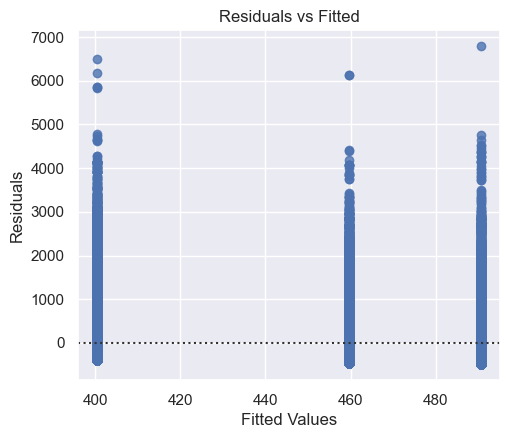

In [23]:
# Plot 1: Residuals vs Fitted
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.residplot(x=fitted_values, y=residuals, line_kws={'color': 'red', 'lw': 2})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Der perfekte Residuen-Plot darf kein Muster aufweisen. Die Residuen sollten sich nach dem Nullpunkt zufällig verteilen. Muster weisen auf Schwierigkeiten im Modell hin (Heteroskedastizität oder Nichtlinearitäten). 

In [24]:
# Polynomielle Regression (2. Grades)
# Polynomial Features erstellen
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Modell erstellen und fitten
quadratisches_modell = sm.OLS(y, sm.add_constant(X_poly)).fit()

# Ergebnisse zusammenfassen
print(quadratisches_modell.summary())

                            OLS Regression Results                            
Dep. Variable:             CO2E_TOTAL   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     422.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:18:23   Log-Likelihood:            -2.1363e+06
No. Observations:              286147   AIC:                         4.273e+06
Df Residuals:                  286141   BIC:                         4.273e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.283e+12   4.88e+12     -0.468      0.6

In [25]:
# Residuen berechnen
residuals_quadtratisch = quadratisches_modell.resid
fitted_values_quadtratisch = quadratisches_modell.fittedvalues

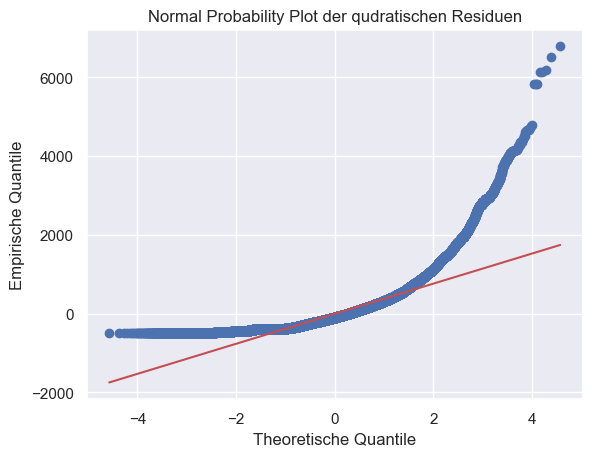

In [26]:
stats.probplot(residuals_quadtratisch, dist="norm", plot=plt)
plt.title('Normal Probability Plot der qudratischen Residuen')
plt.xlabel('Theoretische Quantile')
plt.ylabel('Empirische Quantile')
plt.show()

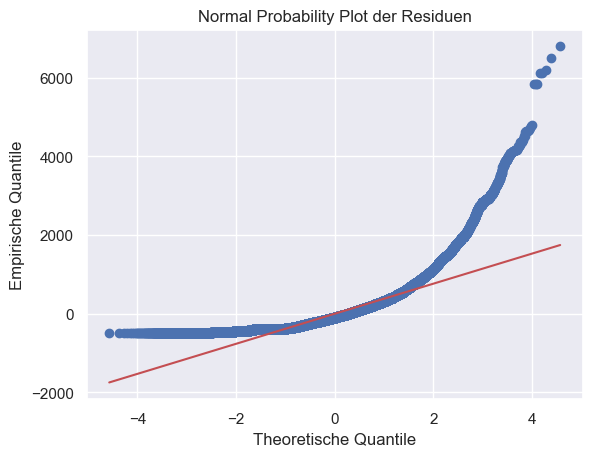

In [27]:
# Normal Probability Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Probability Plot der Residuen')
plt.xlabel('Theoretische Quantile')
plt.ylabel('Empirische Quantile')
plt.show()

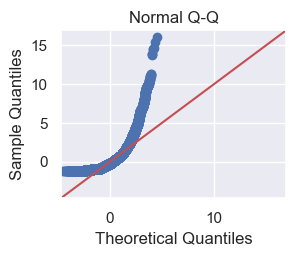

In [28]:
# Plot 2: QQ Plot (Quantile-Quantile plot)
plt.subplot(2, 2, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Normal Q-Q')
plt.show()

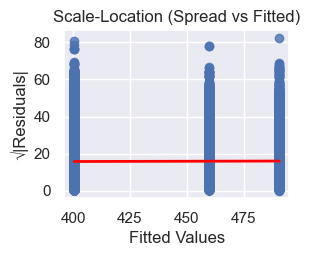

In [29]:
# Plot 3: Scale-Location (Residuals vs Fitted with sqrt of abs residuals)
plt.subplot(2, 2, 3)
sns.regplot(x=fitted_values, y=np.sqrt(np.abs(residuals)), scatter=True, line_kws={'color': 'red', 'lw': 2})
plt.title('Scale-Location (Spread vs Fitted)')
plt.xlabel('Fitted Values')
plt.ylabel('√|Residuals|')
plt.show()

Der Scale-Location-Plot zeigt eine relativ flache rote Linie und eine gleichmässige Streuung der Residuen über die angepassten Werte.
Dies deutet auf Homoskedastizität hin, was bedeutet, dass die Varianz der Residuen konstant ist.
In diesem Fall gibt es keine Anzeichen für Heteroskedastizität, und das Modell ist robust gegenüber der Annahme der konstanten Varianz der Residuen.

In [30]:
# Um Verzerrungen zu reduzieren, wird eine Log-Transformation der Zielvariable durchgeführt

train['log_CO2E_TOTAL'] = np.log1p(train['CO2E_TOTAL'])
model_log = sm.OLS(train['log_CO2E_TOTAL'], X).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:         log_CO2E_TOTAL   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2367.
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:18:47   Log-Likelihood:            -5.1365e+05
No. Observations:              286147   AIC:                         1.027e+06
Df Residuals:                  286144   BIC:                         1.027e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.2503      0.003   15

Interpretation:

Das R-squared liegt bei 0.016, was darauf hinweist, dass das Modell nur 1,6 % der Varianz in den logarithmierten CO₂-Emissionen erklärt. Diese niedrige Erklärungskraft deutet darauf hin, dass weiterhin relevante Prädiktoren im Modell fehlen.

Signifikanz der Prädiktoren: Beide Variablen HH_STADT_LAND_2 (intermediär) und HH_STADT_LAND_3 (ländlich) sind hoch signifikant (p < 0.001).

Koeffizienteninterpretation: 

- HH_STADT_LAND_2 (intermediär): Ein Wechsel von der Referenzkategorie HH_STADT_LAND_1 (städtisch) zu HH_STADT_LAND_2 (intermediär) führt zu einer Erhöhung des CO₂-Ausstosses um +30,28 %.
- HH_STADT_LAND_3 (ländlich): Ein Wechsel von HH_STADT_LAND_1 (städtisch) zu HH_STADT_LAND_3 (ländlich) führt zu einer Erhöhung des CO₂-Ausstosses um +46,64 %.

Die Koeffizienten geben die prozentuale Änderung des CO₂-Ausstosses (in logarithmierter Form) relativ zur Referenzklasse an. Ländlichere Regionen sind mit einem zunehmenden CO₂-Ausstoss assoziiert, was plausibel ist.

In [31]:
# Residuen berechnen
residuals_log = model_log.resid
fitted_values_log = model_log.fittedvalues

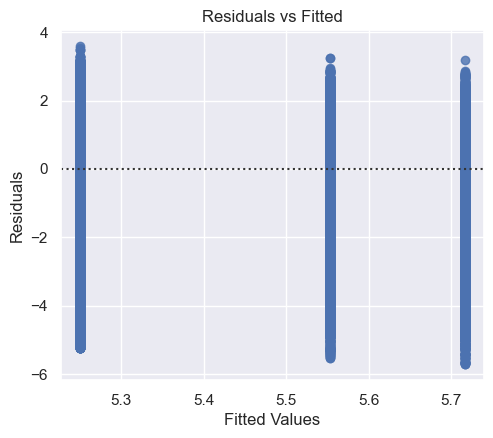

In [32]:
# Plot 1: Residuals vs Fitted
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.residplot(x=fitted_values_log, y=residuals_log, line_kws={'color': 'red', 'lw': 2})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Das Muster in den Residuen zeigt keine zufällige Verteilung um die Null-Linie. Die Vertikalität deutet darauf hin, dass die Residuen durch die diskrete Natur der Raumstruktur beeinflusst werden. Es könnten zusätzliche Prädiktoren fehlen, die die Zielvariable erklären, oder die Transformation könnte unzureichend sein.

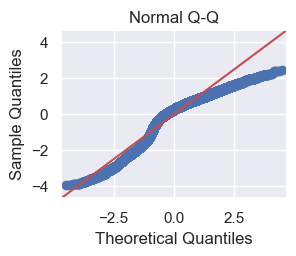

In [33]:
# Plot 2: QQ Plot (Quantile-Quantile plot)
plt.subplot(2, 2, 2)
sm.qqplot(residuals_log, line='45', fit=True, ax=plt.gca())
plt.title('Normal Q-Q')
plt.show()

Der Q-Q-Plot zeigt deutliche Verbesserungen im Vergleich zu vorher. Die Punkte folgen nun weitgehend der roten Linie, insbesondere im mittleren Bereich. Dies deutet auf eine verbesserte Residuenverteilung hin.

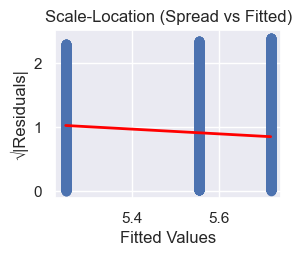

In [34]:
# Plot 3: Scale-Location (Residuals vs Fitted with sqrt of abs residuals)
plt.subplot(2, 2, 3)
sns.regplot(x=fitted_values_log, y=np.sqrt(np.abs(residuals_log)), scatter=True, line_kws={'color': 'red', 'lw': 2})
plt.title('Scale-Location (Spread vs Fitted)')
plt.xlabel('Fitted Values')
plt.ylabel('√|Residuals|')
plt.show()

Die rote Linie (√|Residuen|) ist nicht horizontal, sondern leicht geneigt. Dies zeigt, dass Heteroskedastizität weiterhin ein Problem ist. Die Varianz der Residuen ändert sich abhängig von den Fitted Values.

In [35]:
# Es wird ein robuster Standardfehler verwendet, um Verzerrungen durch Heteroskedastizität zu reduzieren:

model_log_HC3 = sm.OLS(train['log_CO2E_TOTAL'], X).fit(cov_type='HC3')
print(model_log_HC3.summary())

                            OLS Regression Results                            
Dep. Variable:         log_CO2E_TOTAL   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2740.
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:19:11   Log-Likelihood:            -5.1365e+05
No. Observations:              286147   AIC:                         1.027e+06
Df Residuals:                  286144   BIC:                         1.027e+06
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.2503      0.004   14

In [36]:
# Residuen berechnen
residuals_log_HC3 = model_log_HC3.resid
fitted_values_log_HC3 = model_log_HC3.fittedvalues

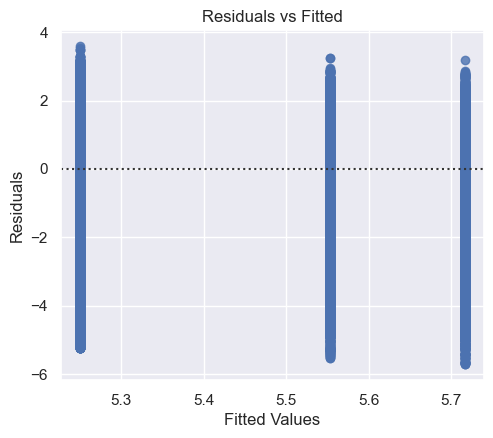

In [37]:
# Plot 1: Residuals vs Fitted
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.residplot(x=fitted_values_log_HC3, y=residuals_log_HC3, line_kws={'color': 'red', 'lw': 2})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

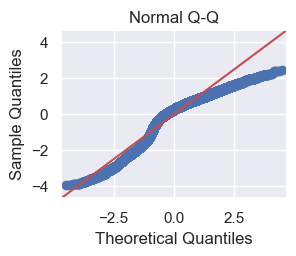

In [38]:
# Plot 2: QQ Plot (Quantile-Quantile plot)
plt.subplot(2, 2, 2)
sm.qqplot(residuals_log_HC3, line='45', fit=True, ax=plt.gca())
plt.title('Normal Q-Q')
plt.show()

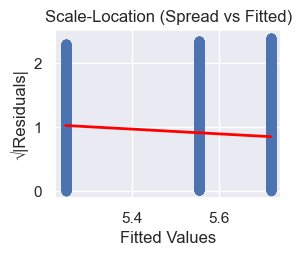

In [39]:
# Plot 3: Scale-Location (Residuals vs Fitted with sqrt of abs residuals)
plt.subplot(2, 2, 3)
sns.regplot(x=fitted_values_log_HC3, y=np.sqrt(np.abs(residuals_log_HC3)), scatter=True, line_kws={'color': 'red', 'lw': 2})
plt.title('Scale-Location (Spread vs Fitted)')
plt.xlabel('Fitted Values')
plt.ylabel('√|Residuals|')
plt.show()

Das Problem, dass die Zielvariable CO2_TOTAL bereits die Emissionen pro Fahrzeugart enthält, könnte die Residuen beeinflussen und die Modellierung erschweren. Dies liegt daran, dass ein wesentlicher Teil der Variation in CO2_TOTAL bereits durch die enthaltenen Emissionsdaten erklärt wird. Dies kann dazu führen, dass die ÖV-Güteklassen oder andere Prädiktoren weniger Einfluss zeigen.

In [40]:
## 3.3. Lineare Regression (Geschlecht, Alter)

X2 = train[['ZP_ALTER', 'ZP_GESL_2']]
X2 = sm.add_constant(X2)
y2 = train['CO2E_TOTAL']

In [41]:
# OLS Modell fitten
model2 = sm.OLS(y2, X2).fit()

In [42]:
# Modell summary ausgeben
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:             CO2E_TOTAL   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     196.6
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           4.70e-86
Time:                        15:19:37   Log-Likelihood:            -2.1372e+06
No. Observations:              286147   AIC:                         4.274e+06
Df Residuals:                  286144   BIC:                         4.274e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        421.3853      2.659    158.448      0.0

Interpretation:

Alter und Geschlecht erklären nur 0.1 % der Variation der abhängigen Variablen.

Wenn alle Prädiktoren (Alter und Geschlecht) gleich 0 sind, beträgt der durchschnittliche CO₂-Ausstoss etwa 421.38. Das ist der Basiswert des Modells.
Pro Jahr zusätzlichem Alter steigt der CO₂-Ausstoss im Durchschnitt um 0,38 kg.
Frauen haben im Vergleich zu Männern durchschnittlich 28,94 kg weniger CO₂-Ausstoss.

In [43]:
## 3.4. Lineare Regression (Geschlecht, Alter, Raumstruktur)
X3 = train[['ZP_ALTER', 'ZP_GESL_2', 'HH_STADT_LAND_2', 'HH_STADT_LAND_3']]
X3 = sm.add_constant(X3)
y3 = train['CO2E_TOTAL']

In [44]:
# Modell fitten
model3 = sm.OLS(y3, X3).fit()

# Zusammenfassung des Modells anzeigen
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:             CO2E_TOTAL   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     624.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:19:37   Log-Likelihood:            -2.1362e+06
No. Observations:              286147   AIC:                         4.272e+06
Df Residuals:                  286142   BIC:                         4.272e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             394.7451      2.715    1

Interpretation:

Das Modell erklärt nun 0,9 % (R2=0.009) der Varianz der Zielvariablen CO2-TOTAL, was immernoch auf eine sehr schlechte Modellgüte hinweist.

Die hohe Anzahl an Beobachtungen (286.147) trägt dazu bei, dass die Koeffizienten statistisch signifikant (p-Werte = 0.000) sind, obwohl die erklärende Stärke gering ist.

Die Koeffizienten geben an, wie sich der CO₂-Ausstoss ändert, wenn Haushalte in unterschiedlichen Raumstrukturen leben, bzw. im Vergleich zur Referenzkategorie HH_STADT_LAND_1 (Städtisch)

HH_STADT_LAND_2 (Intermediär): Haushalte in intermediären Regionen emittieren im Durchschnitt 59.64 kg mehr CO₂ als Haushalte in städtischen Regionen.

HH_STADT_LAND_3 (Ländlich): Haushalte in ländlichen Regionen emittieren im Durchschnitt 89.45 kg mehr CO₂ als Haushalte in städtischen Regionen.

Zwischen diesen 3 Raumtypen, werden die meisten CO₂-Emissionen in ländlichen Räumen emittiert.

## 3.5. Residuen

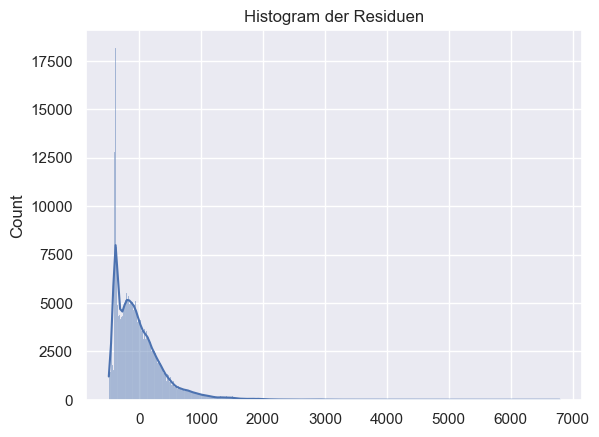

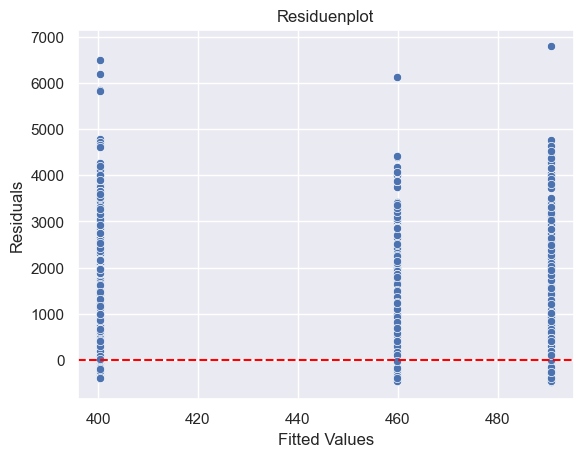

In [45]:
# Residuen berechnen (Model 1: nur Raumstruktur)
residuals = model.resid

# Histogramm der Residuen
sns.histplot(residuals, kde=True)
plt.title('Histogram der Residuen')
plt.show()

# Residuenplot
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuenplot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Interpretation:

Die Residuen sind nicht gleichmässig verteilt, was darauf hindeutet, dass das Modell möglicherweise nicht alle relevanten Variablen berücksichtigt. Die Raumstruktur allein erklärt den CO₂-Ausstoss vermutlich nicht ausreichend, was zu den grossen Restabweichungen führt. Dies deutet auf einen sehr niedrigen R²-Wert hin (wie bereits erläutert).

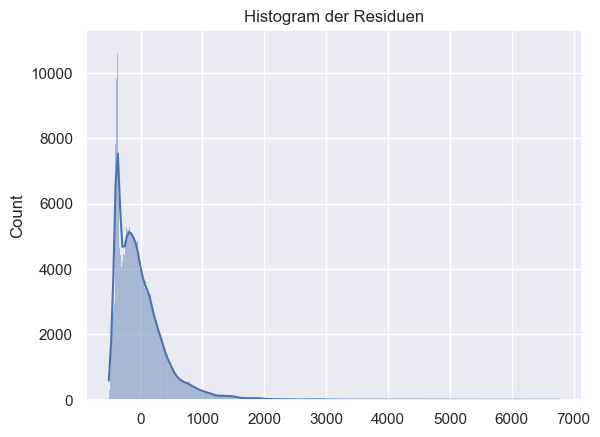

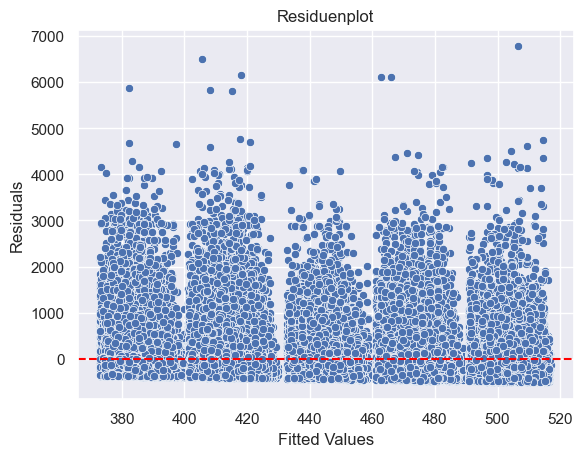

In [46]:
# Residuen berechnen (Model 3: Geschlecht, Alter, Raumstruktur)
residuals = model3.resid

# Histogramm der Residuen
sns.histplot(residuals, kde=True)
plt.title('Histogram der Residuen')
plt.show()

# Residuenplot
sns.scatterplot(x=model3.fittedvalues, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuenplot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Interpretation:

- Das Histogramm zeigt eine rechtsschiefe Verteilung der Residuen (ein Grossteil konzentriert sich bei niedrigen Werten, während einige grosse Werte auftreten).

- Die Residuen sind nicht normalverteilt

- Es gibt kein offensichtliches Muster zwischen den Residuen und den vorhergesagten Werten (fitted values), aber die Streuung nimmt für grössere Werte zu.

- Residuen scheinen hauptsächlich positiv zu sein, mit wenigen negativen Ausreissern.

Es gibt kein erkennbares Muster in den Fehlern des Modells, was bedeutet, dass die Vorhersagen im Durchschnitt nicht systematisch in eine Richtung falsch liegen. Allerdings streuen die Fehler bei grösseren Vorhersagewerten stärker, was darauf hindeuten könnte, dass die Genauigkeit des Modells für höhere Werte schlechter wird.


Modell 1: Sehr schwache Anpassung, da nur ein Prädiktor (Raumstruktur) genutzt wurde, der nicht ausreicht, um den CO₂-Ausstoss zu erklären.
Modell 3: Leicht bessere Anpassung, da mehrere Variablen hinzugefügt wurden. Dennoch deutet die Verteilung der Residuen darauf hin, dass wichtige Prädiktoren fehlen oder die Beziehung nicht linear ist.

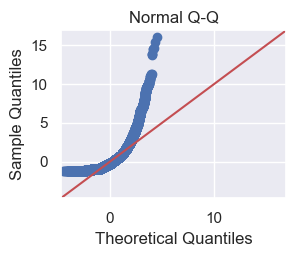

In [47]:
# Plot 2: QQ Plot (Quantile-Quantile plot)
plt.subplot(2, 2, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Normal Q-Q')
plt.show()

Auch bei diesem Modell sind die Residuen nicht gleichverteilt um 0 und somit nicht normalverteilt. Obwohl weitere Parameter hinzugefügt werden, wird das Modell nicht besser.

## Erweiterung (komplexeres Modell)

In [48]:
## 3.6. Hinzunahme Variablen (Geschlecht, Alter, Raumstruktur, Haushaltseinkommen)
X4 = train[['ZP_ALTER', 'ZP_GESL_2', 'HH_HAUSHALTSEINKOMMEN_2', 'HH_HAUSHALTSEINKOMMEN_3', 'HH_HAUSHALTSEINKOMMEN_4', 'HH_HAUSHALTSEINKOMMEN_5', 'HH_HAUSHALTSEINKOMMEN_6', 'HH_HAUSHALTSEINKOMMEN_7',
                    'HH_HAUSHALTSEINKOMMEN_8', 'HH_HAUSHALTSEINKOMMEN_9', 'HH_STADT_LAND_2', 'HH_STADT_LAND_3']]
X4 = sm.add_constant(X4)
y4 = train['CO2E_TOTAL']

In [49]:
# Modell anpassen
model4 = sm.OLS(y4, X4).fit()

# Zusammenfassung des Modells anzeigen
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:             CO2E_TOTAL   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     228.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:19:43   Log-Likelihood:            -2.1360e+06
No. Observations:              286147   AIC:                         4.272e+06
Df Residuals:                  286134   BIC:                         4.272e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## Auswertung des komplexeren Modells


- 1 Unter CHF 2000
- 2 CHF 2000 bis 4000
- 3 CHF 4001 bis 6000
- 4 CHF 6001 bis 8000
- 5 CHF 8001 bis 10000
- 6 CHF 10001 bis 12000
- 7 CHF 12001 bis 14000
- 8 CHF 14001 bis 16000
- 9 Mehr als CHF 16000

Interpretation: 

Einkommensstufen (2 bis 7): Mit steigendem Einkommen wächst der CO₂-Ausstoss (Ausreisser bei Einkommen 4001 bis 6000)
Einkommensstufen (8 und 9): Bei hohem Einkommen sinkt der CO₂-Ausstoss wieder
Beispiel:

CHF 2000-4000 (+25.53 kg)
CHF 4001-6000 (+61.84 kg)
CHF 6001-8000 (+49.79 kg)
Höchste Kategorie (>16000): +35.97 kg
Der signifikante Anstieg des CO₂-Ausstosses bei mittleren und hohen Einkommen könnte darauf hindeuten, dass wohlhabendere Haushalte häufiger CO₂-intensive Verkehrsmittel wie Autos oder Flugzeuge nutzen. Bei sehr hohem Einkommen nimmt der CO2-Ausstoss anschliessend ab.

### Residuen Analyse komplexere Modell

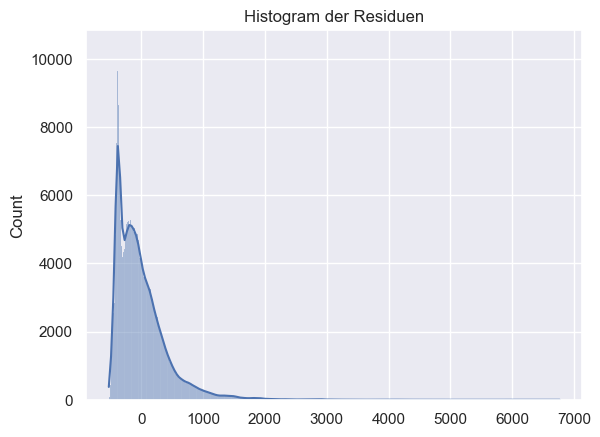

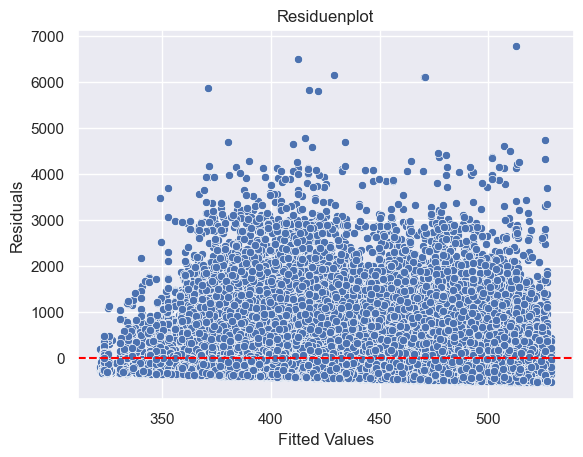

In [50]:
# Residuen berechnen (Model 4: Geschlecht, Alter, Raumstruktur, Haushaltseinkommen)
residuals = model4.resid

# Histogramm der Residuen
sns.histplot(residuals, kde=True)
plt.title('Histogram der Residuen')
plt.show()

# Residuenplot
sns.scatterplot(x=model4.fittedvalues, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuenplot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Interpretation:

Die Residuen sind dichter gestreut als in Modell 1 und Modell 3, was darauf hindeutet, dass Modell 4 eine bessere Anpassung bietet.
Dennoch gibt es Reststruktur. Es scheint, dass die Varianz der Residuen mit höheren Fitted Values leicht zunimmt (ein Trichtermuster ist erkennbar), was zunächst auf eine mögliche Heteroskedastizität hinweist. Allerdings zeigte der Scale-Location-Plot keine signifikanten Anzeichen für Heteroskedastizität. Die Annahme einer konstanten Varianz der Residuen bleibt für das Modell auch nach Hinzunahme zusätzlicher Variablen weiterhin gültig.

Es gibt immer noch einige Ausreisser (Residuals > 5000), aber ihre Anzahl ist reduziert. Das Hinzufügen von Haushaltseinkommen scheint die Modellanpassung verbessert zu haben.

- Modell 1: Sehr schlechte Anpassung, nur Raumstruktur als Prädiktor.
- Modell 3: Verbesserung durch Hinzufügen von Geschlecht und Alter.
- Modell 4: Haushaltseinkommen reduziert Residuen und erhöht die Modellgüte, aber das Modell bleibt unvollständig.

### ANOVA (Analysis of Variance)

In [51]:
# Formelbasierte Spezifikation des Modells
modell4 = smf.ols('CO2E_TOTAL ~ ZP_ALTER + ZP_GESL_2 + HH_HAUSHALTSEINKOMMEN_2 + HH_HAUSHALTSEINKOMMEN_3 + HH_HAUSHALTSEINKOMMEN_4 + HH_HAUSHALTSEINKOMMEN_5 + HH_HAUSHALTSEINKOMMEN_6 + HH_HAUSHALTSEINKOMMEN_7 + HH_HAUSHALTSEINKOMMEN_8 + HH_HAUSHALTSEINKOMMEN_9 + HH_STADT_LAND_2 + HH_STADT_LAND_3', data=train).fit()

# ANOVA durchführen
anova_tabelle = anova_lm(modell4, typ=2)

# Ergebnisse anzeigen
print(anova_tabelle)



                               sum_sq        df            F         PR(>F)
ZP_ALTER                 1.239783e+07       1.0    69.495911   7.690612e-17
ZP_GESL_2                5.251929e+07       1.0   294.396391   5.911994e-66
HH_HAUSHALTSEINKOMMEN_2  1.606522e+06       1.0     9.005342   2.692148e-03
HH_HAUSHALTSEINKOMMEN_3  9.520946e+06       1.0    53.369571   2.770585e-13
HH_HAUSHALTSEINKOMMEN_4  5.944843e+06       1.0    33.323759   7.810376e-09
HH_HAUSHALTSEINKOMMEN_5  1.000535e+07       1.0    56.084865   6.960715e-14
HH_HAUSHALTSEINKOMMEN_6  8.199805e+06       1.0    45.963927   1.206827e-11
HH_HAUSHALTSEINKOMMEN_7  8.372083e+06       1.0    46.929627   7.372961e-12
HH_HAUSHALTSEINKOMMEN_8  3.069264e+06       1.0    17.204728   3.356967e-05
HH_HAUSHALTSEINKOMMEN_9  3.781483e+06       1.0    21.197068   4.145759e-06
HH_STADT_LAND_2          1.546827e+08       1.0   867.072224  2.725396e-190
HH_STADT_LAND_3          2.892143e+08       1.0  1621.187714   0.000000e+00
Residual    

Interpretation:
- Alle Prädiktoren (Alter, Geschlecht, Haushaltseinkommen, und Raumstruktur) haben signifikante Auswirkungen auf den CO2-Ausstoss, da die p-Werte für alle Variablen sehr klein sind. 
- Insbesondere die Raumstruktur (Stadt vs. Land) und das Geschlecht zeigen sehr starke Einflüsse.
- HH_STADT_LAND_3 zeigt den stärksten Effekt (F = 1621.18 p < 0.001).
- Der Fehlerterm (Residual) hat eine sehr hohe Summe der Quadrate (5.104531e+10), was typisch ist, da er die verbleibende Variabilität im CO2-Ausstoss widerspiegelt, die nicht durch die erklärenden Variablen erfasst wird. - Das bedeutet jedoch nicht zwangsläufig, dass das Modell schlecht ist – es kann einfach sein, dass es zusätzliche Variablen gibt, die den CO2-Ausstoss beeinflussen und die noch nicht in das Modell aufgenommen wurden.

In [52]:
# Gesamt-Sum of Squares (Total SS)
total_ss = anova_tabelle['sum_sq'].sum()  # Gesamte Variation der CO2E_TOTAL

# Modell-Sum of Squares (Model SS) = Summe der Quadrate des Modells
model_ss = anova_tabelle['sum_sq'][:-1].sum()  # Alle Variablen außer dem Residualwert

# Residual-Sum of Squares (Residual SS)
residual_ss = anova_tabelle.loc['Residual', 'sum_sq']  # Residualwert aus der ANOVA-Tabelle

# Berechnung des R²-Werts
r_squared = model_ss / total_ss

# Ausgabe der Ergebnisse
print(f"Gesamt SS: {total_ss}")
print(f"Modell SS: {model_ss}")
print(f"Residual SS: {residual_ss}")
print(f"R²: {r_squared}")

Gesamt SS: 51604626444.34306
Modell SS: 559314346.8815737
Residual SS: 51045312097.46149
R²: 0.010838453553865151


Das Verhältnis zwischen der Summe der Quadrate des Modells (Model SS) und der Summe der Quadrate des Fehlers (Residual SS) in deinem Fall deutet darauf hin, dass das Modell wenig erklärende Kraft hat und das Verhältnis nicht akzeptabel ist.